In [1]:

# Class Neural Network with one hidden layer

class NeuralNetwork:
    def __init__(self, inputs_nodes, hidden_nodes, outputs_nodes, learning_rating, bias):
        self.input_nodes = inputs_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = outputs_nodes
        self.lr = learning_rating
        self.bias = bias
        
        np.random.seed()
        
        self.nscale = 1 / self.input_nodes ** (-0.5)
        self.w12 = np.random.normal(scale = self.nscale, size = (self.input_nodes, self.hidden_nodes))
        self.w23 = np.random.normal(scale = self.nscale, size = (self.hidden_nodes, self.output_nodes))
        self.b12 = np.random.normal(scale = self.nscale, size = (1, self.hidden_nodes))
        self.b23 = np.random.normal(scale = self.nscale, size = (1, self.output_nodes))
        
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        deriv_sigmoid = lambda x: (1 / (1 + np.exp(-x)))*(1 - 1 / ((1 + np.exp(-x))))
        
        linear = lambda x: x
        deriv_linear = lambda x: 1
        
        self.act_func = sigmoid
        self.deriv_act_func = deriv_sigmoid
        
        self.act_func_out = linear
        self.deriv_act_func_out = deriv_linear
    
    def show_fdebug(self, x, phi12, output):            
        print('w12', self.w12.shape)
        print('w23', self.w23.shape)
        print('w23_wo_bias')
        print('np.append(x, self.bias)', np.append(x, self.bias).shape)
        print('phi12', phi12.shape)
        print('output', output.shape)
        print('b12', self.b12.shape)
        print('b23', self.b23.shape)
        return None     
    def show_bdebug(self, hidden_error, output_error_term, hidden_error_term):
        print('hidden_error', hidden_error.shape)
        print('output_error_term', output_error_term.shape)
        print('hidden_error_term', hidden_error_term.shape)
        return None    
            
    def shuffle_data(self, features, targets):
        df1 = pd.DataFrame(features)
        df2 = pd.DataFrame(targets)
        df = pd.concat([df1, df2], axis = 1)
        df = df.sample(frac = 1)
    
        features = df.iloc[:, :features.shape[1]].values
        targets = df.iloc[:, features.shape[1]:].values
        return features, targets  
   
    def feedforward(self, x): 
        
        phi12 = self.act_func(np.dot(x, self.w12) + (self.bias * self.b12))
        dphi12 = self.deriv_act_func(np.dot(x, self.w12) + (self.bias * self.b12))
        output = self.act_func_out(np.dot(phi12, self.w23) + (self.bias * self.b23))
        doutput = self.deriv_act_func_out(np.dot(phi12, self.w23) + (self.bias * self.b23))

        #self.show_fdebug(x, phi12, output)
        return phi12, dphi12, output, doutput
    def backforward(self, phi12, dphi12, output, doutput, error):
        
        output_error_term = error * doutput
        hidden_error = np.dot(output_error_term, self.w23.T)
        hidden_error_term = hidden_error * dphi12
        
        #self.show_bdebug(hidden_error, output_error_term, hidden_error_term)
        return output_error_term, hidden_error_term   
    def update_weights(self, x, phi12, output_error_term, hidden_error_term, dw12, dw23, db12, db23):
        
        dw12 += hidden_error_term*x.reshape(self.input_nodes, 1)
        dw23 += output_error_term*phi12.reshape(self.hidden_nodes, 1)
        
        self.w12 += self.lr*dw12/self.input_nodes
        self.w23 += self.lr*dw23/self.input_nodes
        
        
        db12 += hidden_error_term*self.bias
        db23 += output_error_term*self.bias
        
        self.b12 += self.lr*db12/self.input_nodes
        self.b23 += self.lr*db23/self.input_nodes
        
        return None
  
    def train(self, features, targets, epochs):
        Total_error_vector = []
        for e in range(epochs):
            features, targets = self.shuffle_data(features, targets)
            error_rms = 0
            dw12, dw23 = np.zeros(self.w12.shape), np.zeros(self.w23.shape) 
            db12, db23 = np.zeros(self.b12.shape), np.zeros(self.b23.shape)
            for x, y in zip(features, targets):
            
                phi12, dphi12, output, doutput = self.feedforward(x)
            
                error = y - output
            
                output_error_term, hidden_error_term = self.backforward(phi12, dphi12, output, doutput, error)
            
                self.update_weights(x, phi12, output_error_term, hidden_error_term, dw12, dw23, db12, db23)
                
                error_rms += np.mean(error**2)
                
            Total_error = error_rms/(2 * features.shape[0])
            
            Total_error_vector.append(Total_error)
            
        return Total_error_vector
    def run(self, features_test):
        aoutput = []
        for x in features_test:
            phi12, dphi12, output, doutput = self.feedforward(x)
            
            aoutput = np.append(aoutput, output)
            
        return aoutput
    
    def train_validation(self, features_train, targets_train, features_test, targets_test, epochs):
        Total_error_vector, Total_error_tv_vector = [], []
        for e in range(epochs):
            features_train, targets_train = self.shuffle_data(features_train, targets_train)
            features_test, targets_test = self.shuffle_data(features_test, targets_test)
            error_rms, error_tv_rms = 0, 0
            dw12, dw23 = np.zeros(self.w12.shape), np.zeros(self.w23.shape)
            db12, db23 = np.zeros(self.b12.shape), np.zeros(self.b23.shape)
            
            for x, y in zip(features_train, targets_train):
            
                phi12, dphi12, output, doutput = self.feedforward(x)
            
                error = y - output
            
                output_error_term, hidden_error_term = self.backforward(phi12, dphi12, output, doutput, error)
            
                self.update_weights(x, phi12, output_error_term, hidden_error_term, dw12, dw23, db12, db23)
                
                error_rms += np.mean(error**2)
                
            Total_error = error_rms/(2 * features_train.shape[0])
            
            Total_error_vector.append(Total_error)
            
            
            for x, y in zip(features_test, targets_test):
                
                error_tv = self.run(features_test) - targets_test
                
                error_tv_rms += np.mean(error_tv**2)
                
            Total_error_tv = error_tv_rms/(2 * features_test.shape[0])
            
            Total_error_tv_vector.append(Total_error_tv)
            
            
            sys.stdout.write("\rProgress: {:2.1f}".format(100 * e/float(epochs)) + "%")
            sys.stdout.flush()
            
        return Total_error_vector, Total_error_tv_vector
    
    
    
# Class Neural Network with two hidden layers
class MultiLayerPerceptron:
    def __init__(self, inputs_nodes, hidden_nodes, outputs_nodes, learning_rating, bias):
        self.input_nodes = inputs_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = outputs_nodes
        self.lr = learning_rating
        self.bias = bias
        
        np.random.seed()
        
        self.nscale = 1 / self.input_nodes ** (-0.5)
        self.w12 = np.random.normal(scale = self.nscale, size = (self.input_nodes, self.hidden_nodes))
        self.w23 = np.random.normal(scale = self.nscale, size = (self.hidden_nodes, self.hidden_nodes))
        self.w34 = np.random.normal(scale = self.nscale, size = (self.hidden_nodes, self.output_nodes))
        
        self.b12 = np.random.normal(scale = self.nscale, size = (1, self.hidden_nodes))
        self.b23 = np.random.normal(scale = self.nscale, size = (1, self.hidden_nodes))
        self.b34 = np.random.normal(scale = self.nscale, size = (1, self.output_nodes))
        
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        deriv_sigmoid = lambda x: (1 / (1 + np.exp(-x)))*(1 - 1 / ((1 + np.exp(-x))))
        
        linear = lambda x: x
        deriv_linear = lambda x: 1
        
        self.act_func = sigmoid
        self.deriv_act_func = deriv_sigmoid
        
        self.act_func_out = linear
        self.deriv_act_func_out = deriv_linear
            
    def shuffle_data(self, features, targets):
        df1 = pd.DataFrame(features)
        df2 = pd.DataFrame(targets)
        df = pd.concat([df1, df2], axis = 1)
        df = df.sample(frac = 1)
    
        features = df.iloc[:, :features.shape[1]].values
        targets = df.iloc[:, features.shape[1]:].values
        return features, targets  
   
    def feedforward(self, x): 
        
        phi12 = self.act_func(np.dot(x, self.w12) + (self.bias * self.b12))
        dphi12 = self.deriv_act_func(np.dot(x, self.w12) + (self.bias * self.b12))
        
        phi23 = self.act_func(np.dot(phi12, self.w23) + (self.bias * self.b23))
        dphi23 = self.deriv_act_func(np.dot(phi12, self.w23) + (self.bias * self.b23))
        
        output = self.act_func_out(np.dot(phi23, self.w34) + (self.bias * self.b34))
        doutput = self.deriv_act_func_out(np.dot(phi23, self.w34) + (self.bias * self.b34))

        return phi12, dphi12, phi23, dphi23, output, doutput
    def backforward(self, phi12, dphi12, phi23, dphi23, output, doutput, error):
        
        output_error_term = error * doutput
        hidden_error23 = np.dot(output_error_term, self.w34.T)
        hidden_error_term23 = hidden_error23 * dphi23
        
        hidden_error12 = np.dot(hidden_error_term23, self.w23.T)
        hidden_error_term12 = hidden_error12 *dphi12
        
        return output_error_term, hidden_error_term23, hidden_error_term12   
    def update_weights(self, x, phi12, phi23, output_error_term,
                                    hidden_error_term23, hidden_error_term12, dw12, dw23, dw34, db12, db23, db34):
        
        dw12 += hidden_error_term12*x.reshape(self.input_nodes, 1)
        dw23 += hidden_error_term23*phi12.reshape(self.hidden_nodes, 1)
        dw34 += output_error_term*phi23.reshape(self.hidden_nodes, 1)
        
        self.w12 += self.lr*dw12/self.input_nodes
        self.w23 += self.lr*dw23/self.input_nodes
        self.w34 += self.lr*dw34/self.input_nodes
        
        
        db12 += hidden_error_term12*self.bias
        db23 += hidden_error_term23*self.bias
        db34 += output_error_term*self.bias
        
        self.b12 += self.lr*db12/self.input_nodes
        self.b23 += self.lr*db23/self.input_nodes
        self.b34 += self.lr*db34/self.input_nodes
        
        return None
  
    def run(self, features_test):
        aoutput = []
        for x in features_test:
            phi12, dphi12, phi23, dphi23, output, doutput = self.feedforward(x)
            
            aoutput = np.append(aoutput, output)
            
        return aoutput
    
    def train_validation(self, features_train, targets_train, features_test, targets_test, epochs):
        Total_error_vector, Total_error_tv_vector = [], []
        for e in range(epochs):
            features_train, targets_train = self.shuffle_data(features_train, targets_train)
            features_test, targets_test = self.shuffle_data(features_test, targets_test)
            error_rms, error_tv_rms = 0, 0
            dw12, dw23, dw34 = np.zeros(self.w12.shape), np.zeros(self.w23.shape), np.zeros(self.w34.shape)
            db12, db23, db34 = np.zeros(self.b12.shape), np.zeros(self.b23.shape), np.zeros(self.b34.shape)
            
            for x, y in zip(features_train, targets_train):
            
                phi12, dphi12, phi23, dphi23, output, doutput = self.feedforward(x)
            
                error = y - output
            
                output_error_term, hidden_error_term23, hidden_error_term12 = self.backforward(phi12,
                                                                        dphi12, phi23, dphi23, output, doutput, error)
            
                self.update_weights(x, phi12, phi23, output_error_term,
                                    hidden_error_term23, hidden_error_term12, dw12, dw23, dw34, db12, db23, db34)
                
                error_rms += np.mean(error**2)
                
            Total_error = error_rms/(2 * features_train.shape[0])
            
            Total_error_vector.append(Total_error)
            
            
            for x, y in zip(features_test, targets_test):
                
                error_tv = self.run(features_test) - targets_test
                
                error_tv_rms += np.mean(error_tv**2)
                
            Total_error_tv = error_tv_rms/(2 * features_test.shape[0])
            
            Total_error_tv_vector.append(Total_error_tv)
            
            
            sys.stdout.write("\rProgress: {:2.1f}".format(100 * e/float(epochs)) + "%")
            sys.stdout.flush()
            
        return Total_error_vector, Total_error_tv_vector


In [2]:
def split_data(features, targets):
    
    n = np.round(0.7*features.shape[0]).astype(int)
    
    features_train, targets_train = features[:n], targets[:n]
    features_test, targets_test = order_data(features[n:], targets[n:])
    
    return features_train, targets_train, features_test, targets_test
def order_data(features, targets):
    df1 = pd.DataFrame(features)
    df2 = pd.DataFrame(targets)
    df = pd.concat([df1, df2], axis = 1)
    df.columns = ['0', '1']
    df = df.sort_values(by = '0')
    features = df.iloc[:, :features.shape[1]].values
    targets = df.iloc[:, features.shape[1]:].values
    return features, targets

def hyper_static(n_features, n_targets):
    hidden_nodes = round((n_features + n_targets)/2) + 1 
    bias = -1
    return hidden_nodes, bias
def frd_features_targets(n_records, n_features, n_targets):
    features = np.random.rand(n_records, n_features)
    targets = np.random.rand(n_records, n_targets)
    #features, targets = order_data(features, targets)
    return features, targets
def frd_targets(n_records, n_features):
    features = np.random.rand(n_records, n_features)
    #targets = features**2 + 0.2*features**2 - (features - 0.1)
    targets = np.sin(features*6.28)
    return features, targets
def print_trainning_results(features_train, targets_train, features_test, aoutput, Total_error_vector, epochs):
    plt.figure(1)
    
    plt.subplot(121)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    n = np.round(0.2*epochs).astype(int)
    plt.plot(range(epochs)[n:], Total_error_vector[n:])
    
    plt.subplot(122)
    plt.scatter(features_train, targets_train)
    plt.scatter(features_test, aoutput)
        
    return plt.show()
def print_trainning_validation(Total_error_vector, Total_error_tv_vector, features_train,
                               targets_train, features_test, aoutput, epochs):
    plt.figure(1)
    
    plt.subplot(121)
    n = np.round(0.001*epochs).astype(int)
    plt.plot(np.array(range(epochs))[n:], Total_error_vector[n:])
    plt.plot(np.array(range(epochs))[n:], Total_error_tv_vector[n:])
    plt.ylim(0, 1)
    
    plt.subplot(122)
    plt.scatter(features_train, targets_train)
    features_test, aoutput = order_data(features_test, aoutput)
    plt.plot(features_test, aoutput)
    plt.ylim(-1, 1)
    
    return plt.show()

Progress: 100.0%

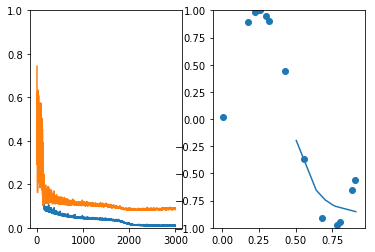

Progress: 100.0%

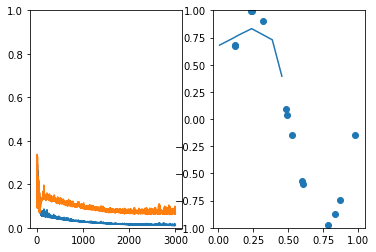

Progress: 100.0%

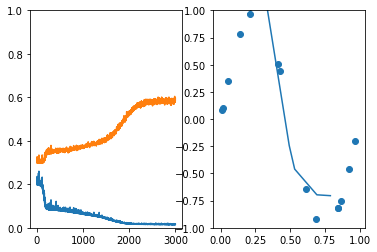

Progress: 100.0%

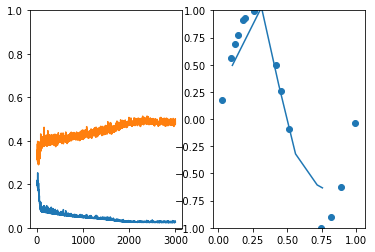

Progress: 100.0%

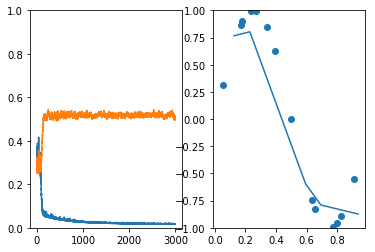

In [5]:
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import sys


def main_network(learning_rate, epochs):
    n_records, n_features, n_targets = 20, 1, 1

    features, targets = frd_targets(n_records, n_features)
    features_train, targets_train, features_test, targets_test = split_data(features, targets)

    hidden_nodes, bias = hyper_static(features.shape[1], targets.shape[1])
    nnx = NeuralNetwork(features.shape[1], hidden_nodes, targets.shape[1], learning_rate, bias)
    nn = MultiLayerPerceptron(features.shape[1], hidden_nodes, targets.shape[1], learning_rate, bias)
    
    Total_error_vector, Total_error_tv_vector = nn.train_validation(
                                                    features_train,targets_train, features_test, targets_test, epochs)
    
    print_trainning_validation(Total_error_vector, Total_error_tv_vector, features_train,
                               targets_train, features_test, nn.run(features_test), epochs)

    return None

def main(loop = 3):
    k = 1
    for i in range(0, loop):
        k *= 0.1
        lr, epochs = 0.01, 3000
        main_network(lr, epochs)
        
main(5)